In [1]:
import pandas as pd 
import spacy

In [2]:
phab_path = "/mmfs1/gscratch/comdata/users/mjilg/mw-repo-lifecycles/case3/050825_coref-rel-final.csv"
phab_df = pd.read_csv(phab_path)

In [3]:
def http_relevant(text):
    if pd.isnull(text):
        return False
    # expanded dictionary for relevancy
    # http, login, SSL, TLS, certificate 
    for word in text.split():
        if "://" not in word.lower():
            #http
            if "http" in word.lower():
                return True
            #login
            if "login" in word.lower():
                return True
            #ssl
            if "ssl" in word.lower():
                return True
            #tls
            if "tls" in word.lower():
                return True
            #cert
            if word.lower().startswith("cert") and not word.lower().startswith("certain"):
                return True
    return False

In [4]:
def is_migrated(comment_text):
    if pd.isnull(comment_text):
        return False
    text = comment_text.strip()
    if text.startswith("Originally from: http://sourceforge.net"):
        return True 
    return False

In [5]:
#find gerrit phab PHID: PHID-USER-idceizaw6elwiwm5xshb
phab_df['isGerrit'] = phab_df['AuthorPHID'] == 'PHID-USER-idceizaw6elwiwm5xshb'

#cleaning df
phab_df['id'] = phab_df.index + 1
#may have to build out the reply_to column 
phab_df['reply_to'] = phab_df.groupby('TaskPHID')['id'].shift()
phab_df['reply_to'] = phab_df['reply_to'].where(pd.notnull(phab_df['reply_to']), None)

phab_df = phab_df.rename(columns={
    'AuthorPHID': 'speaker',
    'TaskPHID': 'conversation_id',
    'WMFaffil':'meta.affil',
    'isGerrit': 'meta.gerrit'
})

# after 07-01-2013 before 10-01-2015
phab_df['timestamp'] = pd.to_datetime(phab_df['date_created'], unit='s', origin='unix', utc=True)
filtered_phab_df = phab_df[(phab_df['date_created'] < 1443743999) & (phab_df['date_created'] > 1372636800)]
#filtered_phab_df = phab_df[(phab_df['date_created'] < 1381691276) & (phab_df['date_created'] > 1379975444)]

#removing headless conversations
task_phab_df = filtered_phab_df[filtered_phab_df['comment_type']=="task_description"]
headed_task_phids = task_phab_df['conversation_id'].unique()
filtered_phab_df = filtered_phab_df[filtered_phab_df['conversation_id'].isin(headed_task_phids)]

#removing gerrit comments 
mid_comment_phab_df = filtered_phab_df[filtered_phab_df['meta.gerrit'] != True]

# filter out the sourceforge migration 
# Originally from: http://sourceforge.net in the task task_summary
migrated_conversation_ids = task_phab_df[task_phab_df['comment_text'].apply(is_migrated)]['conversation_id'].unique()

#cut down to only the data that is relevant (mentions http)
relevant_conversation_ids = task_phab_df[
    task_phab_df['comment_text'].apply(http_relevant) |
    task_phab_df['task_title'].apply(http_relevant)
]['conversation_id'].unique()

task_phab_df['is_relevant'] = task_phab_df['conversation_id'].isin(relevant_conversation_ids)
mid_comment_phab_df['is_relevant'] = mid_comment_phab_df['conversation_id'].isin(relevant_conversation_ids)

task_phab_df['is_migrated'] = task_phab_df['conversation_id'].isin(migrated_conversation_ids)
mid_comment_phab_df['is_migrated'] = mid_comment_phab_df['conversation_id'].isin(migrated_conversation_ids)

comment_phab_df = mid_comment_phab_df[(mid_comment_phab_df['is_relevant'] == True) & (mid_comment_phab_df['is_migrated'] != True)]
task_phab_df = task_phab_df[(task_phab_df['is_relevant'] == True) & (task_phab_df['is_migrated'] != True)]
#comment_phab_df = mid_comment_phab_df

/tmp/ipykernel_34086/836739196.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mid_comment_phab_df['is_relevant'] = mid_comment_phab_df['conversation_id'].isin(relevant_conversation_ids)
/tmp/ipykernel_34086/836739196.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mid_comment_phab_df['is_migrated'] = mid_comment_phab_df['conversation_id'].isin(migrated_conversation_ids)


In [8]:
unique_conversation_ids = len(comment_phab_df['conversation_id'].unique())
unique_ids = len(comment_phab_df['id'].unique())
unique_speakers = len(comment_phab_df['speaker'].unique())

print(f"Unique conversation_ids: {unique_conversation_ids}")
print(f"Unique ids: {unique_ids}")
print(f"Unique speakers: {unique_speakers}")

Unique conversation_ids: 2281
Unique ids: 14490
Unique speakers: 634


In [9]:
given_date = pd.Timestamp("2015-07-02").tz_localize(None)
task_phab_df['timestamp'] = pd.to_datetime(task_phab_df['timestamp'], unit='s').dt.tz_localize(None)
task_phab_df['week_bin'] = ((task_phab_df['timestamp'] - given_date).dt.days // 7)

In [10]:
task_phab_df
task_phab_df.to_csv("/mmfs1/gscratch/comdata/users/mjilg/mw-repo-lifecycles/case3/phab_tasks.csv", index=False)

In [7]:
import re

def preprocess_text(text):
    text = str(text)
    text = text.replace('*', ' ')
    text = text.replace('-', ' ')
    text = re.sub(r'http\S+', '', text)
    return text

In [8]:
comment_phab_df['processed_text'] = comment_phab_df['comment_text'].apply(preprocess_text)

/tmp/ipykernel_34086/2783900859.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df['processed_text'] = comment_phab_df['comment_text'].apply(preprocess_text)


In [ ]:
#comment_phab_df['processed_resolved_text'] = comment_phab_df['resolved_text'].apply(preprocess_text)

In [9]:
nlp = spacy.load("en_core_web_sm")

def extract_dependency_tree(text):
    doc = nlp(text)
    dependency_trees = []
    
    for sentence in doc.sents:
        for token in sentence:
            token_info = (
                token.text, 
                token.lemma_, 
                token.dep_, 
                token.head.text, 
                list(token.ancestors), 
                list(token.subtree), 
                list(token.children)
            )
            dependency_trees.append(token_info)
        
    return dependency_trees

In [10]:
comment_phab_df['dependency_tree'] = comment_phab_df['processed_text'].apply(extract_dependency_tree)

/tmp/ipykernel_34086/2805711855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df['dependency_tree'] = comment_phab_df['processed_text'].apply(extract_dependency_tree)


In [ ]:
#comment_phab_df['resolved_dependency_tree'] = comment_phab_df['processed_resolved_text'].apply(extract_dependency_tree)

In [11]:
#get VAD scores
import numpy as np
#https://saifmohammad.com/WebPages/nrc-vad.html
column_headings = ['Word', 'Valence', 'Arousal', 'Domination']
vad_lexicon = pd.read_csv('NRC-VAD-Lexicon.txt', delimiter='\t', header=None, names=column_headings)
vad_dict = vad_lexicon.set_index('Word').T.to_dict()

def vad_scoring(dependency_tree):
    valence = []
    arousal = []
    dominance = []
    for token, lemma, dep, head, ancestors, subtree, children in dependency_tree:
        if lemma in vad_dict:
            valence.append(vad_dict[lemma]['Valence'])
            arousal.append(vad_dict[lemma]['Arousal'])
            dominance.append(vad_dict[lemma]['Domination'])

    # Compute average scores across the comment
    avg_valence = np.mean(valence) if valence else 0
    avg_arousal = np.mean(arousal) if arousal else 0
    avg_dominance = np.mean(dominance) if dominance else 0

    return [avg_valence, avg_arousal, avg_dominance]

def dominance_prevail(dependency_tree):
    dominant_words = 0 
    for token, lemma, dep, head, ancestors, subtree, children in dependency_tree:
        if lemma in vad_dict:
            if vad_dict[lemma]['Domination'] >= 0.75:
                dominant_words += 1
            if vad_dict[lemma]['Domination'] <= 0.25:
                dominant_words += 1
    return dominant_words

def arousal_prevail(dependency_tree):
    arousal_words = 0 
    for token, lemma, dep, head, ancestors, subtree, children in dependency_tree:
        if lemma in vad_dict:
            if vad_dict[lemma]['Arousal'] >= 0.75:
                arousal_words += 1
            if vad_dict[lemma]['Arousal'] <= 0.25:
                arousal_words += 1
    return arousal_words

def valence_prevail(dependency_tree):
    valence_words = 0 
    for token, lemma, dep, head, ancestors, subtree, children in dependency_tree:
        if lemma in vad_dict:
            if vad_dict[lemma]['Valence'] >= 0.75:
                valence_words += 1
            if vad_dict[lemma]['Valence'] <= 0.25:
                valence_words += 1
    return valence_words
    

In [12]:
#establishing per-comment VAD scores 
comment_phab_df['avg_vad_scores'] = comment_phab_df['dependency_tree'].apply(vad_scoring)
comment_phab_df['dominant_wc'] = comment_phab_df['dependency_tree'].apply(dominance_prevail)
comment_phab_df['arousal_wc'] = comment_phab_df['dependency_tree'].apply(arousal_prevail)
comment_phab_df['valence_wc'] = comment_phab_df['dependency_tree'].apply(valence_prevail)

/tmp/ipykernel_34086/2858732056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df['avg_vad_scores'] = comment_phab_df['dependency_tree'].apply(vad_scoring)
/tmp/ipykernel_34086/2858732056.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df['dominant_wc'] = comment_phab_df['dependency_tree'].apply(dominance_prevail)
/tmp/ipykernel_34086/2858732056.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [13]:
comment_phab_df[['average_v_score', 'average_a_score', 'average_d_score']] = pd.DataFrame(comment_phab_df['avg_vad_scores'].tolist(), index=comment_phab_df.index)
comment_phab_df = comment_phab_df.drop(columns=['avg_vad_scores'])

/tmp/ipykernel_34086/335308388.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df[['average_v_score', 'average_a_score', 'average_d_score']] = pd.DataFrame(comment_phab_df['avg_vad_scores'].tolist(), index=comment_phab_df.index)
/tmp/ipykernel_34086/335308388.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df[['average_v_score', 'average_a_score', 'average_d_score']] = pd.DataFrame(comment_phab_df['avg_vad_scores'].tolist(), index=comment_phab_df.index)
/tmp/ipykernel_34086

In [14]:
# expand the dependency parser 

#pattern = r'\b(ve|VE|visualeditor|VisualEditor)\b'
#pattern = r'\b(WMF|Foundation)\b'
#pattern = r'\b(bots|scripts|gadgets)\b'
pattern = r'\b(http|https)\b'

dependency_relations = []
resolved_dependency_relations = []

for index, row in comment_phab_df.iterrows():
    text = row['comment_text']
    timestamp = row['timestamp']
    comment_id = row['id']
    conversation_id = row['conversation_id']
    WMFaffil = row['meta.affil']
    
    for token, lemma, dep, head, ancestors, subtree, children in row['dependency_tree']:
        if re.search(pattern, token, re.IGNORECASE):
            dependency_relations.append({
                'comment_id': comment_id,
                'timestamp': timestamp,
                'wmfAffil':WMFaffil,
                'token': token,
                'dependency': dep,
                'head': head,
                'depth': len(list(ancestors)), 
                'children': len(list(children)) 
            })
    '''        
    for token, lemma, dep, head, ancestors, subtree, children in row['resolved_dependency_tree']:
        if re.search(pattern, token, re.IGNORECASE):
            resolved_dependency_relations.append({
                'comment_id': comment_id,
                'timestamp': timestamp,
                'wmfAffil':WMFaffil,
                'token': token,
                'dependency': dep,
                'head': head,
                'depth': len(list(ancestors)), 
                'children': len(list(children)) 
            })
    '''
#resolved_dependency_relations_df = pd.DataFrame(resolved_dependency_relations)            
dependency_relations_df = pd.DataFrame(dependency_relations)

In [15]:
#now analysis/plotting 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

In [16]:
given_date = pd.Timestamp("2015-07-02").tz_localize(None)
task_phab_df['timestamp'] = pd.to_datetime(task_phab_df['timestamp'], unit='s').dt.tz_localize(None)
#task_phab_df = task_phab_df[(task_phab_df['date_created'] < 1380585599) & (task_phab_df['date_created'] > 1352592000)]
task_phab_df['week_bin'] = ((task_phab_df['timestamp'] - given_date).dt.days // 7)

In [18]:
task_phab_df
#task_phab_df.to_csv("/mmfs1/gscratch/comdata/users/mjilg/mw-repo-lifecycles/case3/phab_tasks.csv", index=False)

/tmp/ipykernel_96995/627627281.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  task_phab_df['week'] = task_phab_df['timestamp'].dt.to_period('W').dt.start_time


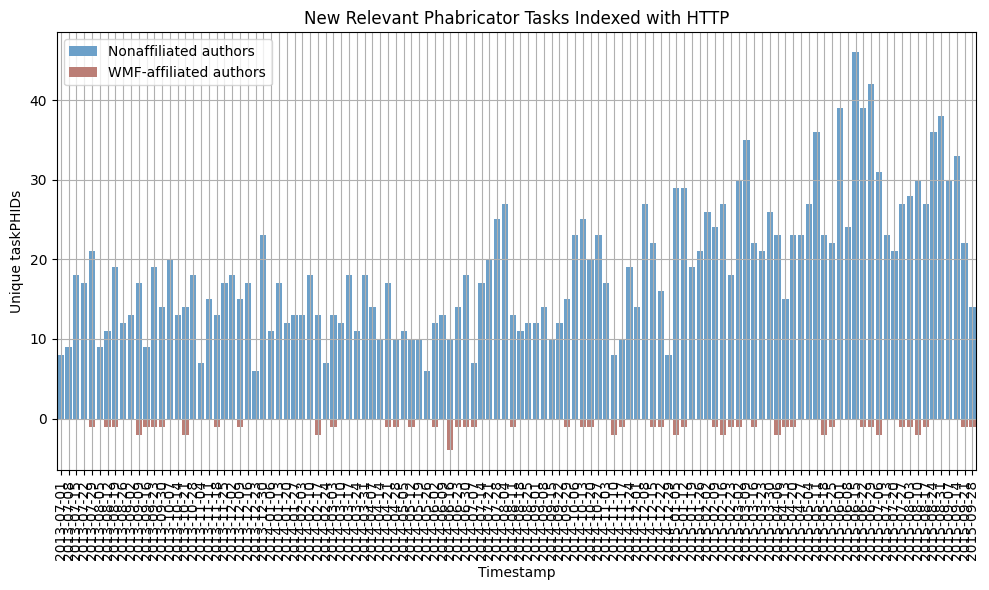

In [18]:
plt.figure(figsize=(10, 6))
#task_phab_df = phab_df[phab_df['comment_type']=="task_description"]
task_phab_df = task_phab_df[task_phab_df['is_relevant'] == True]
task_phab_df['first_comment'] = task_phab_df.groupby('speaker')['timestamp'].rank(method='first') <= 5
#task_phab_df = task_phab_df[(task_phab_df['date_created'] < 1383264000) & (task_phab_df['date_created'] > 1351728000)]

task_phab_df['week'] = task_phab_df['timestamp'].dt.to_period('W').dt.start_time
unique_taskPHIDs = task_phab_df.groupby('week')['conversation_id'].nunique()

wmf_task_phab_df = task_phab_df[(task_phab_df['meta.affil'] == True)]
wmf_tasks = wmf_task_phab_df.groupby('week')['conversation_id'].nunique()

other_task_phab_df = task_phab_df[(task_phab_df['meta.affil'] != True)]
other_tasks = other_task_phab_df.groupby('week')['conversation_id'].nunique()

'''
task_phab_df['speakers_task'] = task_phab_df.groupby('speaker')['timestamp'].rank(method='first').astype(int)

# Filter dates 06-12-2015 to 10-01-2015
bounded_task_phab_df = task_phab_df[(task_phab_df['date_created'] < 1443743999) & (task_phab_df['date_created'] > 1434067200)]
# Bin the speakers based on the number of tasks they created
bins = [0, 6, 26, 51, float('inf')]
labels = ['0-5', '6-25', '26-50', '51+']
min_speakers_task = bounded_task_phab_df.groupby('speaker')['speakers_task'].min().reset_index()
min_speakers_task = bounded_task_phab_df.rename(columns={'speakers_task': 'min_speakers_task'})
bounded_task_phab_df = bounded_task_phab_df.merge(min_speakers_task, on='speaker', how='left')
bounded_task_phab_df['task_bins'] = pd.cut(bounded_task_phab_df ['min_speakers_task'], bins=bins, labels=labels, right=False)
print(bounded_task_phab_df)
bounded_task_phab_df['week'] = bounded_task_phab_df['timestamp_y'].dt.to_period('W').dt.start_time
weekly_breakdown = bounded_task_phab_df.groupby(['week', 'task_bins']).size().unstack(fill_value=0)
speaker_breakdown = bounded_task_phab_df.groupby(['week', 'task_bins']).nunique()['speaker'].unstack(fill_value=0)

# Reshape the DataFrame for use with Seaborn
weekly_breakdown = weekly_breakdown.reset_index().melt(id_vars='week', value_vars=labels, var_name='task_bins', value_name='count')
speaker_breakdown = speaker_breakdown.reset_index().melt(id_vars='week', value_vars=labels, var_name='task_bins', value_name='speakers')

rookie_bounded_task_phab_df = weekly_breakdown[weekly_breakdown['task_bins'] == '0-5']

#unaff_new_tasks_phab_df = task_phab_df[(task_phab_df['first_comment'] == True) & (task_phab_df['meta.affil'] != True)]
#unaff_new_tasks = unaff_new_tasks_phab_df.groupby('week')['conversation_id'].nunique()

#aff_new_tasks_phab_df = task_phab_df[(task_phab_df['first_comment'] == True) & (task_phab_df['meta.affil'] == True)]
#aff_new_tasks = aff_new_tasks_phab_df.groupby('week')['conversation_id'].nunique()

#sns.lineplot(x=unique_taskPHIDs.index, y=unique_taskPHIDs.values, color='black', label='Total', marker='o')
#sns.lineplot(x=wmf_tasks.index, y=wmf_tasks.values, color='#c7756a', label='WMF-affiliated authors', marker='o')
#sns.lineplot(x=other_tasks.index, y=other_tasks.values, color='#5da2d8', label='Nonaffiliated authors', marker='o')
#sns.lineplot(x=aff_new_tasks.index, y=aff_new_tasks.values, color='#c7756a',linestyle="dotted", label="WMF-affiliated new authors", marker='x')
#sns.lineplot(x=unaff_new_tasks.index, y=unaff_new_tasks.values, color='#5da2d8', linestyle="dotted", label="Nonaffiliated new authors", marker='x')
'''
#sns.barplot(x=unique_taskPHIDs.index, y=unique_taskPHIDs.values, color='black', label='Total')
sns.barplot(x=other_tasks.index, y=other_tasks.values, color='#5da2d8', label='Nonaffiliated authors')
sns.barplot(x=wmf_tasks.index, y=-wmf_tasks.values, color='#c7756a', label='WMF-affiliated authors')
#sns.lineplot(data=rookie_bounded_task_phab_df, x='week', y='count', color='green', label='Authors with ≤ 5 tasks', marker='o')

plt.title('New Relevant Phabricator Tasks Indexed with HTTP')
plt.xlabel('Timestamp')
plt.ylabel('Unique taskPHIDs')
plt.xticks(rotation=90)
# Customize the x-axis for weekly labels
plt.grid(True)
plt.tight_layout()
plt.show()

#plt.savefig('031825_new_tasks_fig.png')

/tmp/ipykernel_96995/3303796756.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unaff_tasks_phab_df['speakers_task'] = unaff_tasks_phab_df.groupby('speaker')['timestamp'].rank(method='first').astype(int)
/tmp/ipykernel_96995/3303796756.py:17: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  unaff_tasks_phab_df['week'] = unaff_tasks_phab_df['timestamp'].dt.to_period('W').dt.start_time
/tmp/ipykernel_96995/3303796756.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekly_breakdown = unaff_tasks_phab_df.grou

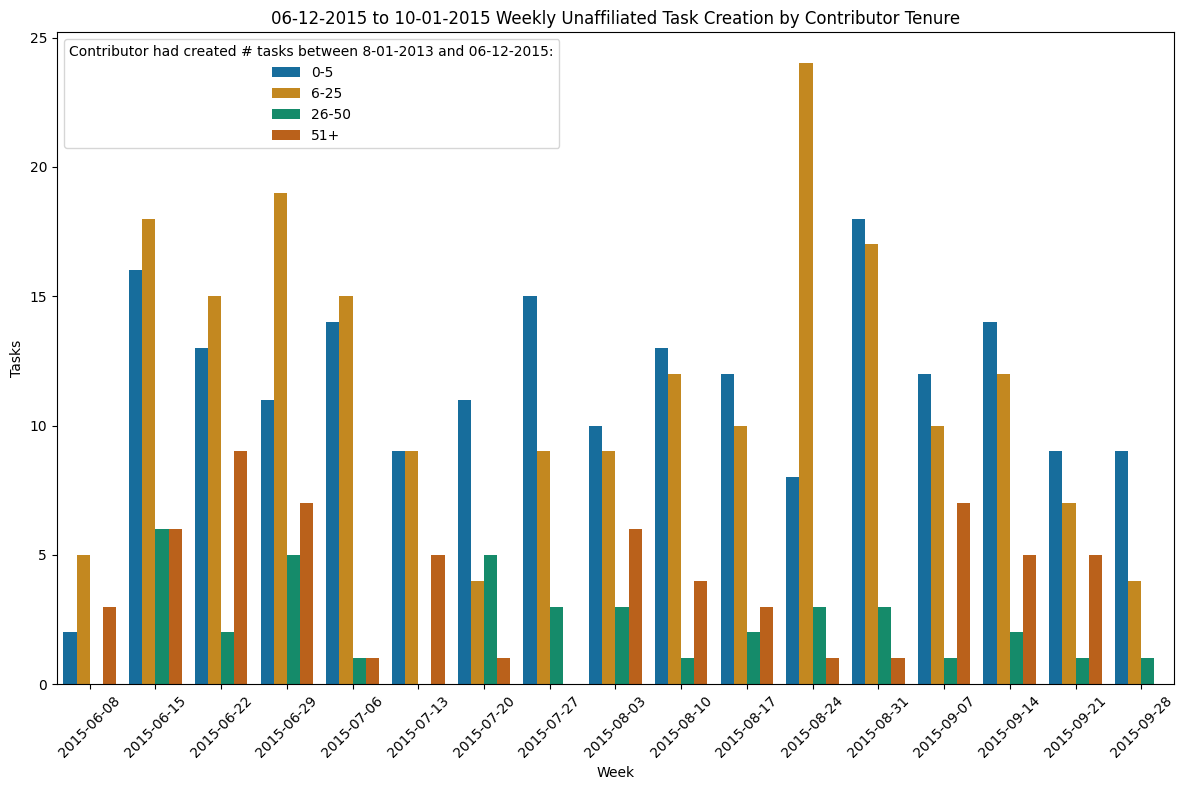

In [19]:
#task_phab_df = phab_df[phab_df['comment_type'] == "task_description"]
unaff_tasks_phab_df = task_phab_df[task_phab_df['meta.affil'] != True]
# Rank speaker's task values within each group
unaff_tasks_phab_df['speakers_task'] = unaff_tasks_phab_df.groupby('speaker')['timestamp'].rank(method='first').astype(int)

# Filter dates 06-12-2015 to 10-01-2015
unaff_tasks_phab_df = unaff_tasks_phab_df[(unaff_tasks_phab_df['date_created'] < 1443743999) & (unaff_tasks_phab_df['date_created'] > 1434067200)]
# Bin the speakers based on the number of tasks they created
bins = [0, 6, 26, 51, float('inf')]
labels = ['0-5', '6-25', '26-50', '51+']
min_speakers_task = unaff_tasks_phab_df.groupby('speaker')['speakers_task'].min().reset_index()
min_speakers_task = min_speakers_task.rename(columns={'speakers_task': 'min_speakers_task'})
unaff_tasks_phab_df = unaff_tasks_phab_df.merge(min_speakers_task, on='speaker', how='left')
unaff_tasks_phab_df['task_bins'] = pd.cut(unaff_tasks_phab_df['min_speakers_task'], bins=bins, labels=labels, right=False)

# Calculate the weekly breakdown of binned speakers_task values
unaff_tasks_phab_df['week'] = unaff_tasks_phab_df['timestamp'].dt.to_period('W').dt.start_time
weekly_breakdown = unaff_tasks_phab_df.groupby(['week', 'task_bins']).size().unstack(fill_value=0)

speaker_breakdown = unaff_tasks_phab_df.groupby(['week', 'task_bins']).nunique()['speaker'].unstack(fill_value=0)

# Reshape the DataFrame for use with Seaborn
weekly_breakdown = weekly_breakdown.reset_index().melt(id_vars='week', value_vars=labels, var_name='task_bins', value_name='count')
speaker_breakdown = speaker_breakdown.reset_index().melt(id_vars='week', value_vars=labels, var_name='task_bins', value_name='speakers')

# Plot the stacked bar plot using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(data=weekly_breakdown, x='week', y='count', hue='task_bins', palette='colorblind')
#sns.barplot(data=speaker_breakdown, x='week', y='speakers', hue='task_bins', palette='colorblind')
plt.title("06-12-2015 to 10-01-2015 Weekly Unaffiliated Task Creation by Contributor Tenure")
plt.xlabel('Week')
plt.ylabel('Tasks')
plt.legend(title="Contributor had created # tasks between 8-01-2013 and 06-12-2015:")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#plt.savefig('031625_weekly_tasks_by_history.png')

/tmp/ipykernel_34086/62586942.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comment_counts = affective_comment_phab_df.groupby('date_group').size()
/tmp/ipykernel_34086/62586942.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  speaker_counts = affective_comment_phab_df.groupby('date_group')['speaker'].nunique()
/tmp/ipykernel_34086/62586942.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comment_counts_en

Number of comments for each date group:
date_group
Before announcement                      10614
After announcement, before deployment      802
After deployment                          3074
dtype: int64

Number of speakers for each date group:
date_group
Before announcement                      521
After announcement, before deployment    142
After deployment                         310
Name: speaker, dtype: int64

Number of comments for each date group and engaged commenter subgroup:
date_group                             est_commenter  meta.affil
Before announcement                    False          False         10317
                                                      True            297
After announcement, before deployment  False          False           787
                                                      True             15
After deployment                       False          False          2992
                                                      True             82

'\nplot1 = sns.lmplot(data=comment_phab_df, x="date_created", y="dominant_wc", hue="date_group", col="meta.affil", row=\'new_commenter\', scatter=False, legend=False, palette=palette)\nplot1.set_axis_labels("Timestamp", "Count of Dominance Polarized Words")\nplot1.set_titles(row_template="Author\'s 100+ Comment: {row_name}",col_template="WMF Affiliation: {col_name}")\nplot1.fig.subplots_adjust(top=0.9)  # Adjust subplots to make room for the title\nplot1.add_legend(title="Comment publication timestamp:")\nfig1 = plot1.fig\n# Plot for arousal_wc\nplot2 = sns.lmplot(data=comment_phab_df, x="date_created", y="arousal_wc", hue="date_group", col="meta.affil", row=\'engaged_commenter\', scatter=False, legend=False, palette=palette)\nplot2.set_axis_labels("Timestamp", "Count of Arousal Polarized Words")\nplot2.set_titles(row_template="Author\'s 100+ Comment: {row_name}",col_template="WMF Affiliation: {col_name}")\nplot2.add_legend(title="Comment publication timestamp:")\n#plot2.add_legend(tit

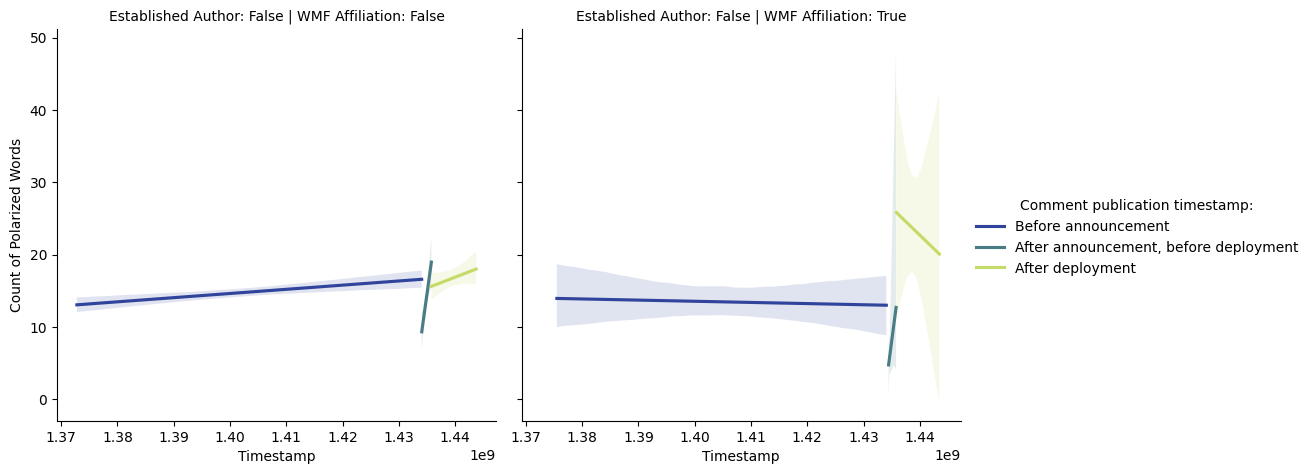

In [19]:
bins = [
    pd.Timestamp('1900-01-01 00:00:01+00:00'),
    pd.Timestamp('2015-06-12 00:00:01+00:00'),
    pd.Timestamp('2015-07-02 00:00:01+00:00'),
    pd.Timestamp('2100-08-28 00:00:01+00:00')
]
labels = ['Before announcement', 'After announcement, before deployment', 'After deployment']

#creating variables of interest
affective_comment_phab_df = comment_phab_df
affective_comment_phab_df['date_group'] = pd.cut(affective_comment_phab_df['timestamp'], bins=bins, labels=labels, right=False)
affective_comment_phab_df['speakers_comment'] = affective_comment_phab_df.groupby('speaker')['timestamp'].rank(method='first').astype(int)
#all comments prior to june 1 2013
subset_comment_phab_df = affective_comment_phab_df[affective_comment_phab_df['date_created'] <= 1370044800]
#getting counts 
comment_counts = subset_comment_phab_df.groupby('speaker')['speakers_comment'].max().reset_index()
comment_counts = comment_counts.rename(columns={'speakers_comment': 'pre_june_2013_comments'})
#merge back 
affective_comment_phab_df = affective_comment_phab_df.merge(comment_counts, on='speaker', how='left')
affective_comment_phab_df['pre_june_2013_comments'] = affective_comment_phab_df['pre_june_2013_comments'].fillna(0)

affective_comment_phab_df['new_commenter'] = affective_comment_phab_df['pre_june_2013_comments'] <= 10
affective_comment_phab_df['est_commenter'] = affective_comment_phab_df['pre_june_2013_comments'] > 50

palette = ['#31449c', '#4a7c85', '#c5db68']

comment_counts = affective_comment_phab_df.groupby('date_group').size()
speaker_counts = affective_comment_phab_df.groupby('date_group')['speaker'].nunique()

print("Number of comments for each date group:")
print(comment_counts)
print("\nNumber of speakers for each date group:")
print(speaker_counts)

comment_counts_engaged = affective_comment_phab_df.groupby(['date_group', 'est_commenter', 'meta.affil']).size()
speaker_counts_engaged = affective_comment_phab_df.groupby(['date_group', 'est_commenter', 'meta.affil'])['speaker'].nunique()

print("\nNumber of comments for each date group and engaged commenter subgroup:")
print(comment_counts_engaged)
print("\nNumber of speakers for each date group and engaged commenter subgroup:")
print(speaker_counts_engaged)

comment_counts_wmf = affective_comment_phab_df.groupby(['est_commenter', 'meta.affil']).size()
speaker_counts_wmf = affective_comment_phab_df.groupby(['est_commenter', 'meta.affil'])['speaker'].nunique()

print("\nNumber of comments for each engaged commenter subgroup, and WMF affiliation:")
print(comment_counts_wmf)
print("\nNumber of speakers for each engaged commenter subgroup, and WMF affiliation:")
print(speaker_counts_wmf)

#comment_phab_df['before_after'] = comment_phab_df['timestamp'] > pd.Timestamp('2013-07-01 00:00:01+00:00')
#fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
affective_comment_phab_df['polarized_wc'] = affective_comment_phab_df['dominant_wc'] + affective_comment_phab_df['valence_wc'] + affective_comment_phab_df['arousal_wc'] 
plot1 = sns.lmplot(data=affective_comment_phab_df, x="date_created", y="polarized_wc", hue="date_group", col="meta.affil", row='est_commenter', scatter=False, legend=False, palette=palette)
plot1.set_axis_labels("Timestamp", "Count of Polarized Words")
plot1.set_titles(row_template="Established Author: {row_name}", col_template="WMF Affiliation: {col_name}")
plot1.fig.subplots_adjust(top=0.9)  # Adjust subplots to make room for the title
plot1.add_legend(title="Comment publication timestamp:")
fig1 = plot1.fig
'''
plot1 = sns.lmplot(data=comment_phab_df, x="date_created", y="dominant_wc", hue="date_group", col="meta.affil", row='new_commenter', scatter=False, legend=False, palette=palette)
plot1.set_axis_labels("Timestamp", "Count of Dominance Polarized Words")
plot1.set_titles(row_template="Author's 100+ Comment: {row_name}",col_template="WMF Affiliation: {col_name}")
plot1.fig.subplots_adjust(top=0.9)  # Adjust subplots to make room for the title
plot1.add_legend(title="Comment publication timestamp:")
fig1 = plot1.fig
# Plot for arousal_wc
plot2 = sns.lmplot(data=comment_phab_df, x="date_created", y="arousal_wc", hue="date_group", col="meta.affil", row='engaged_commenter', scatter=False, legend=False, palette=palette)
plot2.set_axis_labels("Timestamp", "Count of Arousal Polarized Words")
plot2.set_titles(row_template="Author's 100+ Comment: {row_name}",col_template="WMF Affiliation: {col_name}")
plot2.add_legend(title="Comment publication timestamp:")
#plot2.add_legend(title="Before/After 07/01/2013 Wide Release")

plot3 = sns.lmplot(data=comment_phab_df, x="date_created", y="valence_wc", hue="date_group", col="meta.affil", row='engaged_commenter', scatter=False, legend=False, palette=palette)
plot3.set_axis_labels("Timestamp", "Count of Valence Polarized Words")
plot3.set_titles(row_template="Author's 100+ Comment: {row_name}",col_template="WMF Affiliation: {col_name}")
plot3.add_legend(title="Comment publication timestamp:")
'''
# Show plots
#fig1.savefig('031725_engaged_commenter_D_scoring_fig.png')
#plot2.fig.savefig('031725_engaged_commenter_A_scoring_fig.png')
#plot3.fig.savefig('031725_engaged_commenter_V_scoring_fig.png')
#plt.savefig('031625_engaged_commenter_VAD_scoring_fig.png')

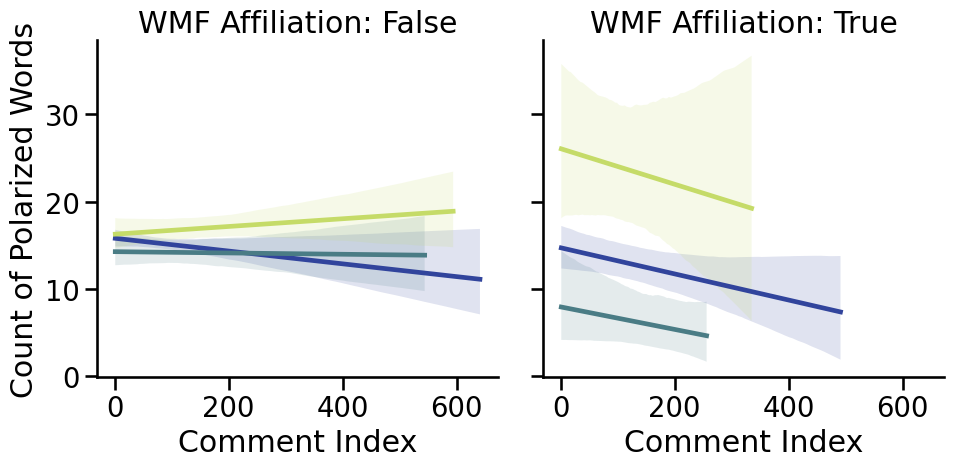

In [26]:
sns.set_context("talk", font_scale=1.2)
plot2 = sns.lmplot(data=affective_comment_phab_df, x="speakers_comment", y="polarized_wc", hue="date_group", col="meta.affil", scatter=False, legend=False, palette=palette)
plot2.set_axis_labels("Comment Index", "Count of Polarized Words")
plot2.set_titles(col_template="WMF Affiliation: {col_name}")
plot2.fig.subplots_adjust(top=0.9)  # Adjust subplots to make room for the title
#plot2.add_legend(title="Comment publication timestamp:")
plot2.fig.savefig('c3-050125_affective_language_use-slides.png')

In [ ]:
#pattern = r'\b(ve|VE|visualeditor|VisualEditor)\b'
#pattern = r'\b(WMF|Foundation)\b'
#pattern = r'\b(bots)\b'
filtered_dependencies = dependency_relations_df[dependency_relations_df['token'].str.contains(pattern, regex=True)]
resolved_filtered_dependencies = resolved_dependency_relations_df[resolved_dependency_relations_df['token'].str.contains(pattern, regex=True)]

plt.figure(figsize=(12, 8))
gs = GridSpec(2, 1, height_ratios=[6, 6])

# Main plot: Token depth by timestamp
'''
ax0 = plt.subplot(gs[0])
sns.scatterplot(data=filtered_dependencies, x='timestamp', y='dependency', hue='wmfAffil', style='dependency', markers=True, s=100, ax=ax0)
ax0.set_title('VE Depth by Timestamp w/o URLS')
ax0.set_xlabel('')
ax0.set_ylabel('Dependency Type')
ax0.legend().set_visible(False)
'''
# Calculate the median depth over time
filtered_dependencies['week'] = filtered_dependencies['timestamp'].dt.to_period('W').dt.start_time
median_depth = filtered_dependencies.groupby('week')['depth'].median().reset_index()

wmf_filtered_dependencies = filtered_dependencies[filtered_dependencies['wmfAffil'] == True]
wmf_median_depth = wmf_filtered_dependencies.groupby('week')['depth'].median().reset_index()

other_filtered_dependencies = filtered_dependencies[filtered_dependencies['wmfAffil'] != True]
other_median_depth = other_filtered_dependencies.groupby('week')['depth'].median().reset_index()

# Plot the median depth over time
ax0 = plt.subplot(gs[0])
sns.lineplot(data=median_depth, x='week', y='depth', ax=ax0, color='black', label='Median Depth', marker='o')
sns.lineplot(data=wmf_median_depth, x='week', y='depth', ax=ax0, color='#c7756a', label='WMF-affiliated authors', marker='x')
sns.lineplot(data=other_median_depth, x='week', y='depth', ax=ax0, color='#5da2d8', label='Nonaffiliated authors', marker='x')
ax0.set_title('Median Depth of "VE" in Phabricator Sentence Dependency Trees')
ax0.set_ylabel('Median Depth')
ax0.set_xlabel('')

# Calculate the median depth over time
resolved_filtered_dependencies['week'] = resolved_filtered_dependencies['timestamp'].dt.to_period('W').dt.start_time
resolved_median_depth = resolved_filtered_dependencies.groupby('week')['depth'].median().reset_index()

resolved_wmf_filtered_dependencies = resolved_filtered_dependencies[resolved_filtered_dependencies['wmfAffil'] == True]
resolved_wmf_median_depth = resolved_wmf_filtered_dependencies.groupby('week')['depth'].median().reset_index()

resolved_other_filtered_dependencies = resolved_filtered_dependencies[resolved_filtered_dependencies['wmfAffil'] != True]
resolved_other_median_depth = resolved_other_filtered_dependencies.groupby('week')['depth'].median().reset_index()

# Plot the median depth over time
ax1 = plt.subplot(gs[1])
sns.lineplot(data=resolved_median_depth, x='week', y='depth', ax=ax1, color='black', label='Median Depth', marker='o')
sns.lineplot(data=resolved_wmf_median_depth, x='week', y='depth', ax=ax1, color='#c7756a', label='WMF-affiliated authors', marker='x')
sns.lineplot(data=resolved_other_median_depth, x='week', y='depth', ax=ax1, color='#5da2d8', label='Nonaffiliated authors', marker='x')
ax1.set_title('Median Depth of "VE" in Coreference-resolved Phabricator Sentence Dependency Trees')
ax1.set_ylabel('Median Depth')
ax1.set_xlabel('')

plt.tight_layout()
#plt.show()

#plt.savefig('031625_VE_depth_fig.png')